In [1]:
import jax.numpy as jnp
import flax
import flax.linen as nn
import numpy as np
from flax.linen.initializers import constant, orthogonal
import jax
import matplotlib.pyplot as plt
import sys
import orbax
import orbax.checkpoint
import gpjax
import optax

/home/james/PycharmProjects/rl_main/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from jax import config

config.update("jax_enable_x64", True)

In [3]:
# %matplotlib notebook

In [4]:
class ContinuousQNetwork(nn.Module):

    @nn.compact
    def __call__(self, s, a):
        # x = jnp.concatenate((s, a), axis=-1)
        x = s
        x = nn.silu(nn.Dense(256, kernel_init=orthogonal(np.sqrt(2.0)))(x))
        x = nn.LayerNorm()(x)
        x = nn.silu(nn.Dense(256, kernel_init=orthogonal(np.sqrt(2.0)))(x))
        x = nn.LayerNorm()(x)
        x = nn.silu(nn.Dense(256, kernel_init=orthogonal(np.sqrt(2.0)))(x))
        x = nn.LayerNorm()(x)
        x = nn.silu(nn.Dense(256, kernel_init=orthogonal(np.sqrt(2.0)))(x))
        x = nn.LayerNorm()(x)
        q_vals = nn.Dense(1, kernel_init=orthogonal(1.0))(x)

        return jnp.squeeze(q_vals, axis=-1)

In [5]:
value_network = ContinuousQNetwork()

In [6]:
def D2_plot_value_function(model_forward_fn, params,
                       x1_bounds=(-10, 10), x2_bounds=(-10, 10),
                       num_points=100, title="Value Function"):
    """
    Creates a 2D plot of the value function over the state space.

    Args:
        model_forward_fn: The forward function of your neural network
        params: The trained parameters of your model
        x1_bounds: Tuple of (min, max) for first state dimension
        x2_bounds: Tuple of (min, max) for second state dimension
        num_points: Number of points to evaluate in each dimension
        title: Title for the plot
    """
    # Create a grid of points
    x1 = np.linspace(x1_bounds[0], x1_bounds[1], num_points)
    x2 = np.linspace(x2_bounds[0], x2_bounds[1], num_points)
    X1, X2 = np.meshgrid(x1, x2)

    # Reshape the grid points into a batch of states
    states = jnp.array([[x1, x2] for x1, x2 in
                        zip(X1.flatten(), X2.flatten())])

    # Vectorized prediction using vmap
    batch_predict = jax.vmap(lambda x: model_forward_fn(params, x))
    values = batch_predict(states)

    # Reshape predictions back to grid
    value_grid = values.reshape(num_points, num_points)

    # Create the plot
    plt.figure(figsize=(10, 8))
    plt.contourf(X1, X2, value_grid, levels=20, cmap='viridis')
    plt.colorbar(label='Value')
    plt.xlabel('State Dimension 1')
    plt.ylabel('State Dimension 2')
    plt.title(title)
    plt.grid(True)

    return plt.gcf()

In [7]:
def plot_value_function(model_forward_fn, params,
                        dim1_idx=0, dim2_idx=1,  # Indices of dimensions to plot
                        bounds=[(-10, 10)] * 8,  # Bounds for all 8 dimensions
                        fixed_values=None,  # Values for non-plotted dimensions
                        num_points=100,
                        title="Value Function",
                        plot_type="2d"):
    import numpy as np
    import jax.numpy as jnp
    import jax
    import matplotlib.pyplot as plt

    # Validate inputs
    assert 0 <= dim1_idx < 8 and 0 <= dim2_idx < 8, "Dimension indices must be between 0 and 7"
    assert dim1_idx != dim2_idx, "Cannot plot the same dimension against itself"
    assert len(bounds) == 8, "Must provide bounds for all 8 dimensions"

    # If fixed values not provided, use midpoints of bounds
    if fixed_values is None:
        fixed_values = [(b[0] + b[1]) / 2 for b in bounds]
    assert len(fixed_values) == 8, "Must provide fixed values for all 8 dimensions"

    # Create grid for the two dimensions we want to plot
    x1 = np.linspace(bounds[dim1_idx][0], bounds[dim1_idx][1], num_points)
    x2 = np.linspace(bounds[dim2_idx][0], bounds[dim2_idx][1], num_points)
    X1, X2 = np.meshgrid(x1, x2)
    x = jnp.stack([X1.flatten(), X2.flatten()], axis=1)

    # Create full state vectors for each grid point
    states = []
    for x1_val, x2_val in zip(X1.flatten(), X2.flatten()):
        state = list(fixed_values)  # Start with fixed values
        state[dim1_idx] = x1_val    # Insert first plotted dimension
        state[dim2_idx] = x2_val    # Insert second plotted dimension
        states.append(state)

    # Convert to jax array
    states = jnp.array(states)

    # Vectorized prediction using vmap
    batch_predict = jax.vmap(lambda x: model_forward_fn(params, x))
    values = batch_predict(states)

    # Reshape predictions back to grid
    value_grid = values.reshape(num_points, num_points)

    # Create the plot
    fig = plt.figure(figsize=(12, 8))

    if plot_type == "2d":
        plt.contourf(X1, X2, value_grid, levels=20, cmap='berlin')
        plt.colorbar(label='Value')
        plt.xlabel(f'State Dimension {dim1_idx}')
        plt.ylabel(f'State Dimension {dim2_idx}')
        plt.title(title)
        plt.grid(True)

    if plot_type == "3d":
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X1, X2, value_grid, cmap='berlin',
                             linewidth=0, antialiased=True)
        fig.colorbar(surf, label='Value')
        ax.set_xlabel(f'State Dimension {dim1_idx}')
        ax.set_ylabel(f'State Dimension {dim2_idx}')
        ax.set_zlabel('Value')
        ax.set_title(title)

        # Rotate the view for better visualization
        ax.view_init(elev=30, azim=45)

    return fig, value_grid, x

/home/james/PycharmProjects/rl_main/.venv/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


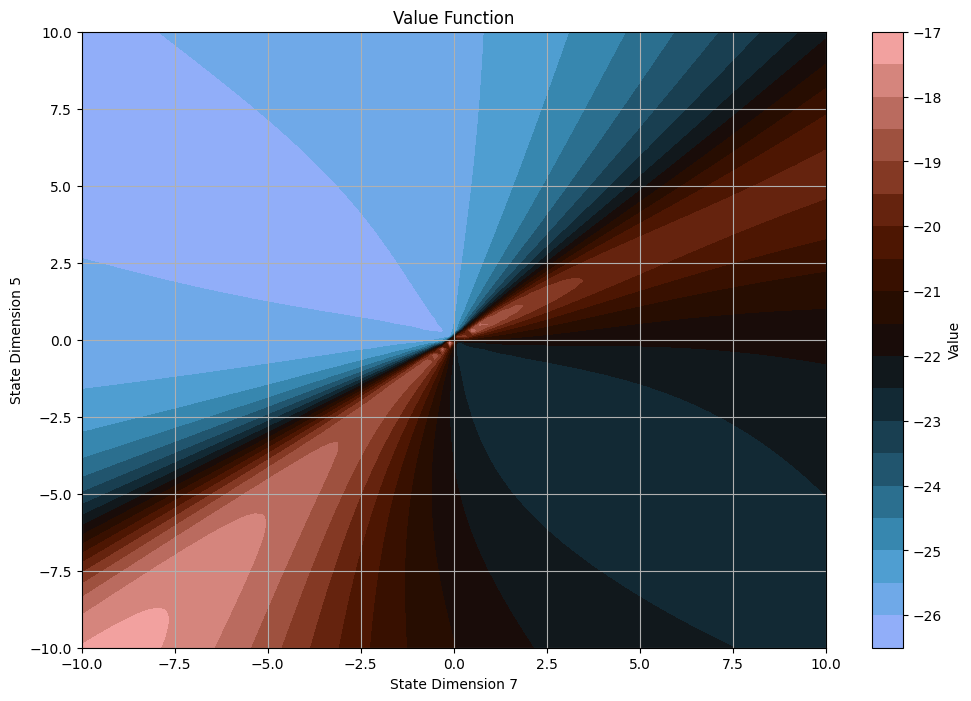

In [13]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
train_state = orbax_checkpointer.restore('/home/james/PycharmProjects/rl_main/project_name/Orbax_Checkpoints/eyyooo')
critic_params = train_state["model"]["critic_state"]["params"]

# Assuming you have already defined your network and loaded params:
def network_forward(params, x):
    # Your network's forward pass implementation
    return value_network.apply(params, x, jnp.zeros((1,)))

# Create the visualization
fig, value_grid, x = plot_value_function(network_forward,
                          critic_params,
                          dim1_idx=7,
                          dim2_idx=5,
                          bounds=[(-10, 10)] * 8,
                          num_points=100,
                          plot_type="2d",
                          )
plt.show()

In [10]:
key = jax.random.PRNGKey(42)

y = jnp.reshape(value_grid, (-1, 1))

def consistent_random_sample(dataset1, dataset2, sample_size, key):
    # Get the total number of samples in the original datasets
    total_samples = dataset1.shape[0]

    # Create a permutation of indices
    permuted_indices = jax.random.permutation(key, total_samples)

    # Take the first sample_size indices
    selected_indices = permuted_indices[:sample_size]

    # Use these indices to sample from both datasets
    sampled_dataset1 = dataset1[selected_indices]
    sampled_dataset2 = dataset2[selected_indices]

    return sampled_dataset1, sampled_dataset2

key, _key = jax.random.split(key)
subsample_x, subsample_y = consistent_random_sample(x, y, sample_size=100, key=_key)

# D = gpjax.Dataset(X=x, y=y)
D = gpjax.Dataset(X=subsample_x, y=subsample_y)

meanf = gpjax.mean_functions.Zero()
kernel = gpjax.kernels.Matern52(active_dims=[0, 1], lengthscale=jnp.array([1.0, 1.0]), variance=2.0)
prior = gpjax.gps.Prior(mean_function=meanf, kernel=kernel)

# Define a likelihood
likelihood = gpjax.likelihoods.Gaussian(num_datapoints=D.n, obs_stddev=gpjax.parameters.Static(jnp.array(1e-6)))

# Construct the posterior
posterior = prior * likelihood

# Define an optimiser
optimiser = optax.adam(learning_rate=1e-2)

# Obtain Type 2 MLEs of the hyperparameters
opt_posterior, history = gpjax.fit(
    model=posterior,
    objective=lambda p, d: -gpjax.objectives.conjugate_mll(p, d),
    train_data=D,
    optim=optimiser,
    num_iters=500,
    safe=True,
    key=key,
)

Running: 100%|██████████| 500/500 [00:01<00:00, 250.46it/s, Value=760.26] 


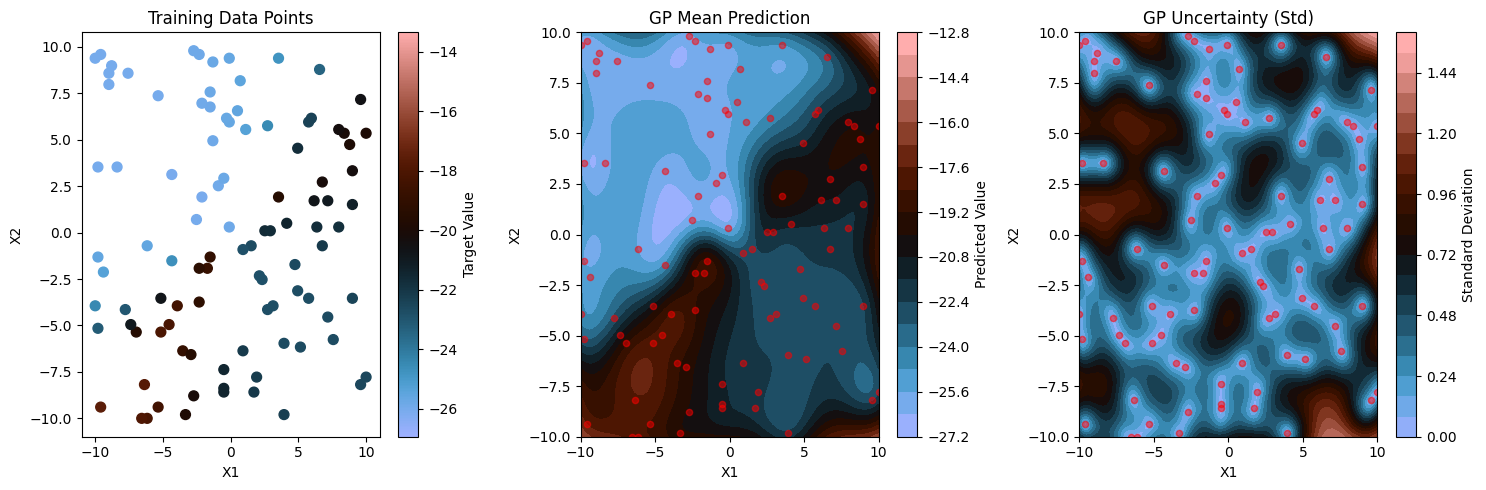

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Create a grid of test points
x1_test = np.linspace(x[:, 0].min(), x[:, 0].max(), 100)
x2_test = np.linspace(x[:, 1].min(), x[:, 1].max(), 100)
X1_test, X2_test = np.meshgrid(x1_test, x2_test)
X_test = jnp.array(np.column_stack([X1_test.ravel(), X2_test.ravel()]))

# Get posterior predictions
latent_dist = opt_posterior.predict(X_test, train_data=D)
mean_prediction = latent_dist.mean().reshape(100, 100)
std_prediction = jnp.sqrt(latent_dist.variance()).reshape(100, 100)

# Determine value ranges for consistent coloring
value_min = min(subsample_y.min(), mean_prediction.min())
value_max = max(subsample_y.max(), mean_prediction.max())

# Create the visualization
plt.figure(figsize=(15, 5))

# Plot 1: Original data points
plt.subplot(131)
scatter = plt.scatter(subsample_x[:, 0], subsample_x[:, 1], c=subsample_y.ravel(),
                     cmap='berlin', s=50, vmin=value_min, vmax=value_max)
cbar = plt.colorbar(scatter)
cbar.set_label('Target Value')
plt.title('Training Data Points')
plt.xlabel('X1')
plt.ylabel('X2')

# Plot 2: GP Mean Prediction
plt.subplot(132)
contour = plt.contourf(X1_test, X2_test, mean_prediction, levels=20,
                      cmap='berlin', vmin=value_min, vmax=value_max)
cbar = plt.colorbar(contour)
cbar.set_label('Predicted Value')
plt.scatter(subsample_x[:, 0], subsample_x[:, 1], c='red', s=20, alpha=0.5)
plt.title('GP Mean Prediction')
plt.xlabel('X1')
plt.ylabel('X2')

# Plot 3: GP Uncertainty (Standard Deviation)
# Note: Uncertainty plot uses its own scale since it's measuring something different
uncertainty_max = std_prediction.max()
plt.subplot(133)
contour = plt.contourf(X1_test, X2_test, std_prediction, levels=20,
                      cmap='berlin', vmin=0, vmax=uncertainty_max)
cbar = plt.colorbar(contour)
cbar.set_label('Standard Deviation')
plt.scatter(subsample_x[:, 0], subsample_x[:, 1], c='red', s=20, alpha=0.5)
plt.title('GP Uncertainty (Std)')
plt.xlabel('X1')
plt.ylabel('X2')

plt.tight_layout()
plt.show()